In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tvt
from torch.utils.data.sampler import SubsetRandomSampler
import torch_directml
import matplotlib.pyplot as plt
import matplotlib.patches as ph
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import random
import os, time, gc, shutil
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import functools

# use directml to run codes on AMD GPU
dml = torch_directml.device()
dml

device(type='privateuseone', index=0)

In [8]:
class SkipBlockDN(nn.Module):
    def __init__(self, in_ch, out_ch, ker=4, *, stride=2, padding=1) -> None:
        super(SkipBlockDN, self).__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.stride = stride
        self.conv1 = nn.Conv2d(in_ch, out_ch, ker, stride=stride, padding=padding, bias=False)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        downsampler = []
        if stride != 1:
            if stride != 2:
                raise ValueError('Currently stride must be 1 or 2.')
            downsampler.append(nn.AvgPool2d(2,2))
        if in_ch != out_ch:
            downsampler.extend([
                nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0, bias=False),#, groups=in_ch//4),
                nn.BatchNorm2d(out_ch)
            ])
        if downsampler != []:
            self.downsampler = nn.Sequential(*downsampler)
        else:
            self.downsampler = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampler is not None:
            identity = self.downsampler(identity)

        out = out + identity
        out = self.relu(out)

        return out
    

class SkipBlockUP(nn.Module):
    def __init__(self, in_ch, out_ch, ker=4, *, stride=2, padding=1) -> None:
        super(SkipBlockUP, self).__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.stride = stride
        self.convT1 = nn.ConvTranspose2d(in_ch, in_ch,    3, stride=1, padding=1, bias=False)
        self.convT2 = nn.ConvTranspose2d(in_ch, out_ch, ker, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(in_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        upsampler = []
        if in_ch != out_ch:
            upsampler.extend([
                nn.ConvTranspose2d(in_ch, out_ch, 1, stride=1, padding=0, bias=False),#, groups=out_ch//4),
                nn.BatchNorm2d(out_ch)
            ])
        if stride != 1:
            if stride != 2:
                raise ValueError('Currently stride must be 1 or 2.')
            upsampler.append(nn.Upsample(scale_factor=stride))
        if upsampler != []:
            self.upsampler = nn.Sequential(*upsampler)
        else:
            self.upsampler = None

    def forward(self, x):
        identity = x

        out = self.convT1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.convT2(out)
        out = self.bn2(out)
        if self.upsampler is not None:
            identity = self.upsampler(identity)

        out = out + identity
        out = self.relu(out)

        return out


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        model = [
            nn.Linear(100, 64),
            nn.LeakyReLU(0.1, True),
            nn.Linear(64,  128),
            nn.LeakyReLU(0.1, True),
            nn.Linear(128,  512),
            nn.LeakyReLU(0.1, True),
            nn.Linear(512, 4096),
            nn.LeakyReLU(0.1, True),
            nn.Unflatten(1, (256,4,4)),
            SkipBlockUP(256,256, ker=4, stride=2, padding=1),
            SkipBlockUP(256,256, ker=4, stride=2, padding=1),
            SkipBlockUP(256,128, ker=4, stride=2, padding=1),
            SkipBlockUP(128,128, ker=4, stride=2, padding=1),
            nn.ConvTranspose2d(128, 3, 3, stride=1, padding=1, bias=True),
            nn.Tanh(),
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        out = self.model(x)
        return(out)

class NetD(nn.Module):
    def __init__(self):
        super().__init__()
        model = [
            nn.Conv2d(    3, 128,     5, stride=1, padding=2, bias=False),
            nn.LeakyReLU(0.1, inplace=True),
            SkipBlockDN(128, 128, ker=4, stride=2, padding=1),
            SkipBlockDN(128, 256, ker=4, stride=2, padding=1),
            SkipBlockDN(256, 256, ker=4, stride=2, padding=1),
            SkipBlockDN(256, 256, ker=4, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(4096, 512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(64,  1),
        ]
        self.model = nn.Sequential(*model)

class Discriminator(NetD):
    def __init__(self):
        super().__init__()
        # super(NetD, self).__init__()


    def forward(self, x):
        out = self.model(x)
        out = torch.sigmoid(out)
        return out

class Critic(NetD):
    def __init__(self):
        # super(NetD, self).__init__()
        super().__init__()
    
    def forward(self, x):
        out = self.model(x)
        out = out.mean(0)
        out = out.view(1)
        return out


class HW7_GAN(nn.Module):
    def __init__(self, *, batch_size=64, use_critic=False) -> None:
        super(HW7_GAN, self).__init__()
        self.batch_size = batch_size
        self.use_critic = use_critic
        self.set_discriminator(use_critic)
        self.set_generator()
        self.set_train_dataloader(batch_size)
        # self.set_test_dataloader()

    def set_train_dataloader(self, batch_size=32, dir=Path.cwd()/"train"):
        dataset = torchvision.datasets.ImageFolder(
            root = dir,
            transform = tvt.Compose([                          
                tvt.ToTensor(),                     
                tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),         
            ])
        )
        self.train_dataloader = torch.utils.data.DataLoader(
            dataset, 
            batch_size = batch_size, 
            shuffle = True, 
            num_workers = 8,
            drop_last=True,
            pin_memory=True
        )

    def set_test_dataloader(self, batch_size=1, dir=Path.cwd()/"train"):
        pass

    def set_generator(self):
        self.generator = Generator()
        self.generator_size = [
            len(list(self.generator.parameters())),
            sum(p.numel() for p in self.generator.parameters() if p.requires_grad)
        ]

    def set_discriminator(self, use_critic):
        self.discriminator = Critic() if use_critic else Discriminator()
        self.discriminator_size = [
            len(list(self.discriminator.parameters())),
            sum(p.numel() for p in self.discriminator.parameters() if p.requires_grad)
        ]

    # Why do we need this?
    def weights_init(self, m):
        classname = m.__class__.__name__     
        if classname.find('Conv') != -1:         
            nn.init.normal_(m.weight.data, 0.0, 0.02)      
        elif classname.find('BatchNorm') != -1:         
            nn.init.normal_(m.weight.data, 1.0, 0.02)       
            nn.init.constant_(m.bias.data, 0)
        # elif classname.find('Linear') != -1:
        #     nn.init.normal_(m.weight.data, 0.0, 0.02)

    def run_code(self, out_dir="fake", *, epochs=20, device=torch_directml.device(), lr=1e-4, beta1=0.5):
        if self.use_critic:
            return self.run_wgan_code(out_dir=out_dir, epochs=epochs, device=device, lr=lr, beta1=beta1)
        out_dir = Path.cwd()/out_dir
        # delete all files in current directory
        if os.path.exists(out_dir):
            shutil.rmtree(out_dir)
        os.mkdir(out_dir)
        self.device = device

        nz = 100
        netD = self.discriminator.to(device)
        netG = self.generator.to(device)
        netD.apply(self.weights_init)
        netG.apply(self.weights_init)
        fixed_noize = torch.randn(self.batch_size, nz, device=device)
        real_labels =torch.ones( self.batch_size, dtype=torch.float, device=device)
        fake_labels =torch.zeros(self.batch_size, dtype=torch.float, device=device)
        optim_D = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
        optim_G = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
        criterion = nn.BCELoss()
        
        loss_record = []
        img_list = []
        # milestones = [1, 5, 10, epochs]
        start_time = time.perf_counter()
        for epoch in range(epochs):
            epoch_start_time = time.perf_counter()
            loss_D_sum = 0.0
            loss_G_sum = 0.0
            batches = 0
            for i, data in enumerate(self.train_dataloader):
                # train discriminator
                netD.zero_grad()
                real_images = data[0].to(device)
                pred_labels = netD(real_images).view(-1)
                loss_D_real = criterion(pred_labels, real_labels)
                loss_D_real.backward()

                noise = torch.randn(self.batch_size, nz, device=device)
                fake_images = netG(noise)
                pred_labels = netD(fake_images.detach()).view(-1)
                loss_D_fake = criterion(pred_labels, fake_labels)
                loss_D_fake.backward()

                optim_D.step()
                loss_D = loss_D_real + loss_D_fake
                loss_D_sum += loss_D
                
                # train generator
                netG.zero_grad()
                pred_labels = netD(fake_images).view(-1)
                loss_G = criterion(pred_labels, real_labels)
                loss_G.backward()

                optim_G.step()
                loss_G_sum += loss_G

                if i%50 == 49:
                    current_time = time.perf_counter()                                                      
                    elapsed_time = current_time - start_time                                                
                    mean_D_loss = loss_D_sum.item() / 50
                    mean_G_loss = loss_G_sum.item() / 50
                    loss_record.extend([mean_D_loss, mean_G_loss])
                    print("\n[epoch %d/%d] [iter %4d] [elapsed time %5d secs]  mean D loss: %7.4f, mean G loss: %7.4f"\
                        %(epoch+1, epochs, i+1, elapsed_time, mean_D_loss, mean_G_loss))
                    loss_D_sum = 0.
                    loss_G_sum = 0.
                batches += 1
            epoch_end_time = time.perf_counter()
            mean_D_loss = loss_D_sum.item() / batches
            print("\n[epoch %d/%d] end. Elapsed time %4f secs/100iter"%\
              (epoch+1, epochs, (epoch_end_time-epoch_start_time)*100/batches)
            )
            if epoch%2 == 1:
                with torch.no_grad():
                    fake_images = netG(fixed_noize).detach().cpu()
                img_list.append(torchvision.utils.make_grid(fake_images, padding=1, pad_value=1, normalize=True))

        return loss_record, img_list
    
    def run_wgan_code(self, out_dir="fake", *, epochs=20, device=torch_directml.device(), lr=1e-4, beta1=0.5):
        out_dir = Path.cwd()/out_dir
        # delete all files in current directory
        if os.path.exists(out_dir):
            shutil.rmtree(out_dir)
        os.mkdir(out_dir)
        self.device = device

        nz = 100
        netD = self.discriminator.to(device)
        netG = self.generator.to(device)
        netD.apply(self.weights_init)
        netG.apply(self.weights_init)
        fixed_noize = torch.randn(self.batch_size, nz, device=device)
        real_grad = torch.FloatTensor([-1]).to(device)
        fake_grad = torch.FloatTensor([+1]).to(device)
        optim_D = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
        optim_G = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
        criterion = None
        
        loss_record = []
        img_list = []
        # milestones = [1, 5, 10, epochs]
        start_time = time.perf_counter()
        for epoch in range(epochs):
            epoch_start_time = time.perf_counter()
            loss_D_sum = 0.0
            loss_G_sum = 0.0
            ncritic = 5
            batches = 0
            ic = 0
            # while batches < len(self.train_dataloader):
            #     for p in netD.parameters():
            #         p.requires_grad = True
            #     ic = 0
            #     while ic < ncritic and batches < len(self.train_dataloader):
            for i, data in enumerate(self.train_dataloader):
                netD.zero_grad()
                real_images = data[0].to(device)    
                pred_critics_real = netD(real_images)
                # loss_D_real = criterion(pred_labels, real_labels)
                pred_critics_real.backward(real_grad)

                noise = torch.randn(self.batch_size, nz, device=device)
                fake_images = netG(noise)
                pred_critics_fake = netD(fake_images.detach())
                # loss_D_fake = criterion(pred_labels, fake_labels)
                pred_critics_fake.backward(fake_grad)

                gradient_penalty = self.calc_gradient_penalty(netD, real_images, fake_images)
                gradient_penalty.backward()
                optim_D.step()

                ic += 1
                if ic < ncritic:
                    continue
                ic = 0

                loss_D_sum += (pred_critics_fake - pred_critics_real + gradient_penalty).item()
                # wasser_dist = (pred_critics_real - pred_critics_fake).item()

                # train generator
                for p in netD.parameters():
                    p.requires_grad = False
                netG.zero_grad()
                noise = torch.randn(self.batch_size, nz, device=device)
                fake_images = netG(noise)
                pred_critics_fake = netD(fake_images)
                pred_critics_fake.backward(real_grad)
                optim_G.step()
                
                loss_G_sum += pred_critics_fake.item()

                # recover netD for next loop
                for p in netD.parameters():
                    p.requires_grad = True
                    
                if i%64 == 63:
                    current_time = time.perf_counter()                                                      
                    elapsed_time = current_time - start_time                                                
                    mean_D_loss = loss_D_sum / 50
                    mean_G_loss = loss_G_sum / 50
                    loss_record.extend([mean_D_loss, mean_G_loss])
                    print("\n[epoch %d/%d] [iter %4d] [elapsed time %5d secs]  mean D loss: %7.4f, mean G loss: %7.4f"\
                        %(epoch+1, epochs, i+1, elapsed_time, mean_D_loss, mean_G_loss))
                    loss_D_sum = 0.
                    loss_G_sum = 0.
                batches += 1
            epoch_end_time = time.perf_counter()
            print("\n[epoch %d/%d] end. Elapsed time %4f secs/100iter"%\
              (epoch+1, epochs, (epoch_end_time-epoch_start_time)*100/batches)
            )
            if epoch%3 == 1:
                with torch.no_grad():
                    fake_images = netG(fixed_noize).detach().cpu()
                img_list.append(torchvision.utils.make_grid(fake_images, padding=1, pad_value=1, normalize=True))

        return loss_record, img_list
            
    # from Prof Kak's code:
    def calc_gradient_penalty(self, netC, real_data, fake_data):
        """
        Implementation by Marvin Cao: https://github.com/caogang/wgan-gp
        Marvin Cao's code is a PyTorch version of the Tensorflow based implementation provided by
        the authors of the paper "Improved Training of Wasserstein GANs" by Gulrajani, Ahmed, 
        Arjovsky, Dumouli,  and Courville.
        """
        BATCH_SIZE = self.batch_size
        LAMBDA = 0.1
        epsilon = torch.rand(1, device=self.device)
        interpolates = epsilon * real_data + ((1 - epsilon) * fake_data)
        interpolates = interpolates.requires_grad_(True).to(self.device)
        critic_interpolates = netC(interpolates)
        gradients = torch.autograd.grad(outputs=critic_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(critic_interpolates.size(), device=self.device), 
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
        return gradient_penalty

    
gan = HW7_GAN(batch_size=4, use_critic=True)
gan.generator_size, gan.discriminator_size

([37, 7022403], [36, 7018625])

In [9]:
loss_record, img_list = gan.run_code(
    epochs=9, 
    lr=0.5e-4, 
    beta1=0.9, 
    # device="cpu"
)

KeyboardInterrupt: 

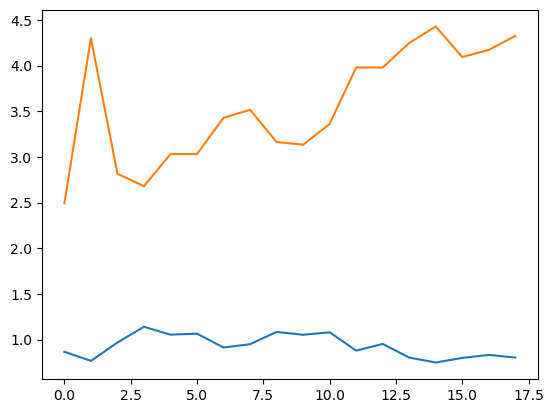

In [15]:
plt.plot(np.array(loss_record).reshape(-1,2))

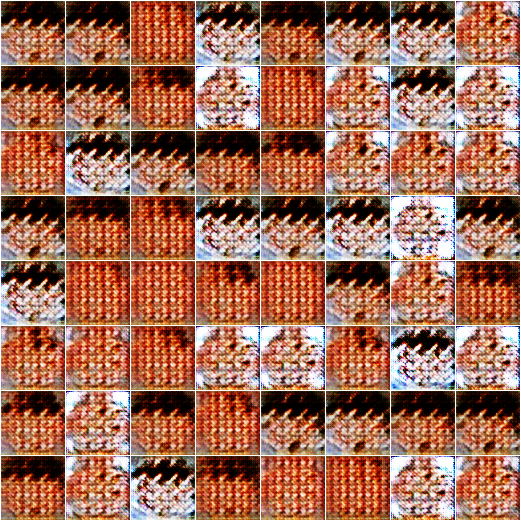

In [16]:
# import imageio
images = []
for imgobj in img_list:  
    img = tvt.functional.to_pil_image(imgobj)
    images.append(img)

# imageio.mimsave(Path.cwd()/"generation_animation.gif", images, fps=1)
images[-1]

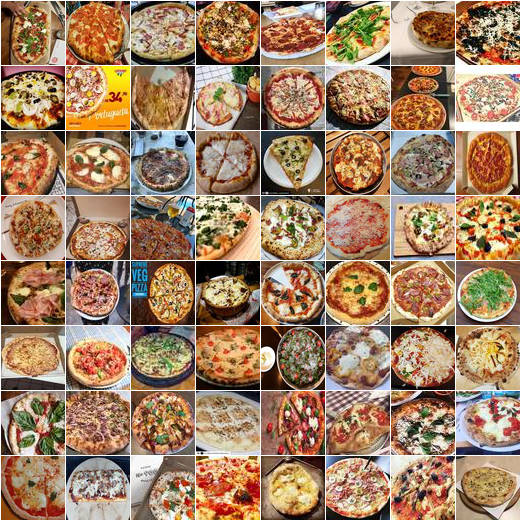

In [28]:
images = next(iter(gan.train_dataloader))[0]
images = torchvision.utils.make_grid(images, padding=1, pad_value=1, normalize=True)
tvt.functional.to_pil_image(images)

In [10]:
def calc2(x, ker=3, *, stride=1, padding=1):
    return (x-1)*stride + ker - 2*padding

calc2(32, ker=4, stride=2, padding=1)

64